# Анализ данных о криптовалютах полученных с CryptoRank.io и bscscan.com

## Объединение данных полученных из разных источников

In [126]:
import json
import pandas as pd
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from sklearn.metrics import recall_score, precision_score
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
import numpy as np

# Функция для конвертации данных из JSON в DataFrame и сохранения в CSV файл
def to_df(filename):
    # Открываем JSON файл для чтения
    with open(filename, 'r', encoding='utf-8') as json_file:
        # Загружаем данные из JSON файла
        data = json.load(json_file)

    # Создаем DataFrame из данных
    df = pd.DataFrame(data)

    # Сохраняем DataFrame в CSV файл с тем же именем, что и у исходного JSON файла, но с расширением .csv
    df.to_csv(f'{filename.split(".json")[0]}.csv', index=False, sep=';')

    # Возвращаем DataFrame
    return df

# Вызываем функцию to_df для файла 'coin_data.json'
scan = to_df('coin_data.json')

# Открываем JSON файл 'contract_data.json' для чтения
with open("contract_data.json", 'r') as json_file:
    # Загружаем данные из JSON файла
    data = json.load(json_file)

In [127]:

dx_df = pd.read_csv('dx_codes.csv')
dx_df = dx_df[['name', 'code', 'is_web_live']]
dx_df['lifeCycle'] = dx_df['is_web_live'].apply(lambda x: int(x))
dx_df.drop(columns=['is_web_live'], inplace=True)
dx_df.head()

,name,code,lifeCycle
0,ZeniCoin,pragma solidity ^0.6.12;\r\n\r\n// SPDX-Licens...,1
1,DexGen,/*\r\n// Official DxFee Token\r\n// To Mint yo...,1
2,BAMBI,// SPDX-License-Identifier: MIT\n\n\n\n\n\n\n\...,1
3,Pinky Swear,/**\r\n// SPDX-License-Identifier: MIT\r\n\r\n...,1
4,RawKit,/*\r\n// Official DxFee Token\r\n// To Mint yo...,1


In [128]:
cryptorank_df = pd.read_csv('cryptorank_codes.csv')
cryptorank_df = cryptorank_df[~(cryptorank_df['lifeCycle'] == 'crowdsale')]
cryptorank_df['lifeCycle'] = cryptorank_df['lifeCycle'].apply(lambda x: 1 if x == 'traded' else 0)
cryptorank_df.head()

,name,code,lifeCycle
0,EOS,pragma solidity 0.5.16;\r\n\r\ninterface IBEP2...,1
1,XRP,pragma solidity 0.5.16;\r\n\r\ninterface IBEP2...,1
2,Cardano,pragma solidity 0.5.16;\r\n\r\ninterface IBEP2...,1
3,Litecoin,/**\r\n *Submitted for verification at Bscscan...,1
4,Bitcoin Cash,pragma solidity 0.5.16;\r\n\r\ninterface IBEP2...,1


In [129]:
# Функция для извлечения информации о монете из словарей
def extract_coin_info(item):
    if item is not None and 'props' in item and 'pageProps' in item['props']:
        return item['props']['pageProps']
    else:
        return None

# Создание нового датафрейма на основе информации о монете
coin_df = pd.json_normalize(scan['items'].apply(extract_coin_info).dropna())
coin_df.head()

,rank,key,name,hasFundingRounds,symbol,type,lifeCycle,unlimitedSupply,totalSupply,percentOfCircSupply,...,histPrices.3Y.BTC,histPrices.3Y.ETH,histPrices.3Y.percentUSD,icoData.kyc,icoData.accepting,icoData.whitelist,icoData.teamFromCountries,athPrice.dateUSD,icoData.rates,isSponsored
0,NaN,patex,Patex,False,PATEX,token,crowdsale,False,8.000000e+06,4.21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1716.0,cyber-arena,Cyber Arena,False,CAT,token,traded,False,5.000000e+09,14.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1699.0,virtual-versions,Virtual Versions,False,VV,token,traded,False,1.000000e+09,11.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1595.0,kryptonite,Kryptonite,False,SEILOR,token,traded,False,1.000000e+09,19.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1120.0,spartadex,SpartaDEX,False,SPARTA,token,traded,False,1.000000e+08,18.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Определим число уникальных данных, продолжать работу будем с ними**

In [130]:
unique_keys_count = coin_df['key'].nunique()
print("Number of unique values in the 'key' column:", unique_keys_count)

Number of unique values in the 'key' column: 1424


In [131]:
yes_columns = ['name', 'lifeCycle']
df_cleaned = coin_df[yes_columns]
df_cleaned.head()

,name,lifeCycle
0,Patex,crowdsale
1,Cyber Arena,traded
2,Virtual Versions,traded
3,Kryptonite,traded
4,SpartaDEX,traded


Добавим ещё столбец - код криптовалюты, для этого получим данные из json, создадим dataFrame и смерджим его с нашим по именам

In [132]:
n_data = list()
n_data = []
for key in data:
    if data[key] == []:
        continue
    n_data.append({'name' : key, 'code' : data[key]['result'][0]})

In [133]:
codes = pd.DataFrame(n_data)

In [134]:
codes.head()

,name,code
0,Patex,{'SourceCode': '// OpenZeppelin Contracts v4.4...
1,Cyber Arena,{'SourceCode': '// File: @openzeppelin/contrac...
2,Virtual Versions,"{'SourceCode': '{{ ""language"": ""Solidity"", ..."
3,Kryptonite,"{'SourceCode': '{{ ""language"": ""Solidity"", ..."
4,SpartaDEX,"{'SourceCode': '{{ ""language"": ""Solidity"", ..."


In [135]:
result_df = pd.merge(codes, df_cleaned.drop_duplicates('name'), on='name', how='left')
result_df.head()

,name,code,lifeCycle
0,Patex,{'SourceCode': '// OpenZeppelin Contracts v4.4...,crowdsale
1,Cyber Arena,{'SourceCode': '// File: @openzeppelin/contrac...,traded
2,Virtual Versions,"{'SourceCode': '{{ ""language"": ""Solidity"", ...",traded
3,Kryptonite,"{'SourceCode': '{{ ""language"": ""Solidity"", ...",traded
4,SpartaDEX,"{'SourceCode': '{{ ""language"": ""Solidity"", ...",traded


In [136]:
result_df = result_df[['name', 'code', 'lifeCycle']]

In [137]:
result_df.head()

,name,code,lifeCycle
0,Patex,{'SourceCode': '// OpenZeppelin Contracts v4.4...,crowdsale
1,Cyber Arena,{'SourceCode': '// File: @openzeppelin/contrac...,traded
2,Virtual Versions,"{'SourceCode': '{{ ""language"": ""Solidity"", ...",traded
3,Kryptonite,"{'SourceCode': '{{ ""language"": ""Solidity"", ...",traded
4,SpartaDEX,"{'SourceCode': '{{ ""language"": ""Solidity"", ...",traded


Статус crowdsale означает что криптовалюта ещё не выпущена, нас это не интересует так что удаляем все строчки где lifeCycle = crowdsale

In [138]:
result_df = result_df[result_df["lifeCycle"] != 'crowdsale']
result_df["lifeCycle"] = result_df["lifeCycle"].apply(lambda x: 1 if x == 'traded' else 0)
result_df['lifeCycle']

1       1
2       1
3       1
4       1
5       1
       ..
1166    1
1167    1
1168    0
1169    1
1170    0
Name: lifeCycle, Length: 1134, dtype: int64

In [139]:
result_df = pd.concat([result_df, dx_df, cryptorank_df], ignore_index=True)
result_df = result_df.drop_duplicates(subset=['name'])
result_df.head()

,name,code,lifeCycle
0,Cyber Arena,{'SourceCode': '// File: @openzeppelin/contrac...,1
1,Virtual Versions,"{'SourceCode': '{{ ""language"": ""Solidity"", ...",1
2,Kryptonite,"{'SourceCode': '{{ ""language"": ""Solidity"", ...",1
3,SpartaDEX,"{'SourceCode': '{{ ""language"": ""Solidity"", ...",1
4,SophiaVerse,"{'SourceCode': '{{ ""language"": ""Solidity"", ...",1


(array([ 689.,    0., 1041.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <BarContainer object of 3 artists>)

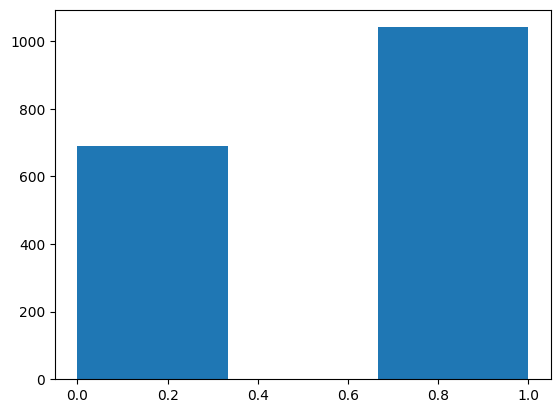

In [140]:
plt.hist(result_df['lifeCycle'], bins=3)

Получили такие данные переведем наш код в числа, для этого воспользуемся tfidf  vectorizer

In [141]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(result_df['code'].astype(str)).toarray()

In [142]:
y = result_df['lifeCycle']
y

0       1
1       1
2       1
3       1
4       1
       ..
1739    0
1740    0
1741    0
1742    1
1743    0
Name: lifeCycle, Length: 1730, dtype: int64

Визуализируем наши данные, для этого воспользуемся методом снижения размерности

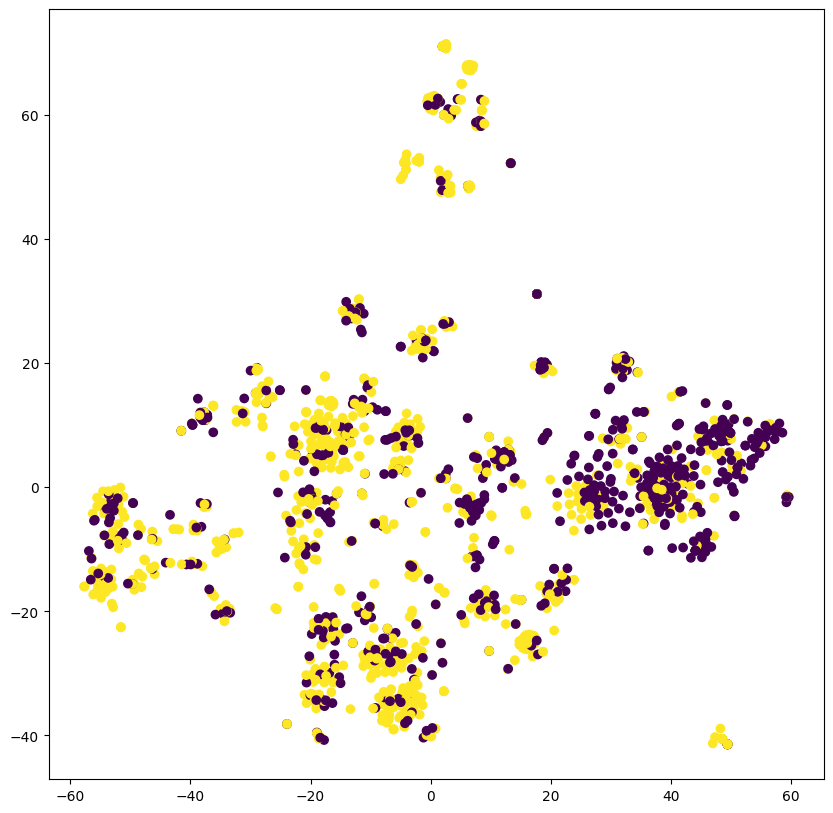

In [143]:
X_embedded = TSNE(n_components=2).fit_transform(X)
plt.figure(figsize=(10, 10))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c = y)
plt.show()

Получив матрицу признаков и столбец ответ поделим наши данные на валидационную, тренировочную и тестовую часть

# Выбор метрики

Наша задача - с наибольшей точностью определять inactive, так как мы не должны навредить нормальным криптовалютам. 
Так же необходим высокий recall так как мы должны определить наибольшее количество криптовалют однодневок. Balanced accuracy в принципе со своей задачей справляется, так как максимизирует sensitivity то есть precision и specifity то есть recall, но оно максимизирует их полусумму, что может вызывать доминацию одного из значений. Воспользуемся f1_score для того, чтобы больше штрафовать за занижение одного из членов.

In [144]:
scoring = 'f1'
score = f1_score

# Обучение на необработанных данных

Посмотрим результаты обучения на не очищенном от комментариев, знаков препинания и т.д. кодах

In [145]:
from sklearn.model_selection import train_test_split

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)
len(X_train), len(X_val), len(X_test)

(1167, 390, 173)

Всё готово для того, чтобы воспользоваться методом ближайших соседей, метрикой качества у нас будет точность или сбалансированная точность так как датасет несбалансирован

In [147]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(score(y_val, y_pred))

0.7438016528925621


Отлично! Теперь можем попробовать подобрать число соседей

In [148]:
param_grid = {
    'n_neighbors': np.arange(1, 25, 2),
}

search = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, scoring=scoring)
search.fit(X_train, y_train)
search.best_params_

{'n_neighbors': 17}

In [149]:
search.best_score_

0.7616160776300767

In [150]:
y_pred = search.predict(X_val)
print(score(y_val, y_pred))

0.7852998065764023


Получаем результат

In [151]:
model = DecisionTreeClassifier()

model.fit(X_train, y_train)

DecisionTreeClassifier()

In [152]:
y_pred = model.predict(X_val)
print(score(y_val, y_pred))

0.7435387673956262


С параметрами по умолчанию получилось хуже чем у лучшего KNN, попробуем добавить поиск гиперпараметров

In [153]:
param_grid = {
    'max_depth': np.arange(1, 15, 2),
}

search = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, scoring=scoring)
search.fit(X_train, y_train)
y_pred = search.predict(X_val)

print(score(y_val, y_pred))
search.best_params_

0.780114722753346


{'max_depth': 1}

Добились ещё одного процента качества

Посмотрим насколько велика ошибка на трейне

как насчёт бэггинга ? Рандомфорест

In [154]:
model = RandomForestClassifier()

model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(score(y_val, y_pred))

0.779324055666004


подберём гиперпараметры для леса

In [155]:
param_grid = {
    'max_depth': np.arange(1, 15, 2),
}

search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, scoring=scoring)
search.fit(X_train, y_train)
y_pred = search.predict(X_val)

print(score(y_val, y_pred))
search.best_params_

0.7950530035335689


{'max_depth': 1}

# Обработка данных

Немножко обработаем код, уберем из него все скобки, знаки \n, \r, знаки препинания

In [156]:
result_df['code'].iloc[0]['SourceCode'][:3000]

'// File: @openzeppelin/contracts/utils/Context.sol\r\n\r\n\r\n// OpenZeppelin Contracts v4.4.1 (utils/Context.sol)\r\n\r\npragma solidity ^0.8.0;\r\n\r\n/**\r\n * @dev Provides information about the current execution context, including the\r\n * sender of the transaction and its data. While these are generally available\r\n * via msg.sender and msg.data, they should not be accessed in such a direct\r\n * manner, since when dealing with meta-transactions the account sending and\r\n * paying for execution may not be the actual sender (as far as an application\r\n * is concerned).\r\n *\r\n * This contract is only required for intermediate, library-like contracts.\r\n */\r\nabstract contract Context {\r\n    function _msgSender() internal view virtual returns (address) {\r\n        return msg.sender;\r\n    }\r\n\r\n    function _msgData() internal view virtual returns (bytes calldata) {\r\n        return msg.data;\r\n    }\r\n}\r\n\r\n// File: @openzeppelin/contracts/access/Ownable.sol\

In [157]:
import re
pattern = re.compile(r'@[a-zA-Z0-9/.]+')
pattern.sub('', str(result_df['code'].iloc[0]))[:3000]

'{\'SourceCode\': \'// File: \\r\\n\\r\\n\\r\\n// OpenZeppelin Contracts v4.4.1 (utils/Context.sol)\\r\\n\\r\\npragma solidity ^0.8.0;\\r\\n\\r\\n/**\\r\\n *  Provides information about the current execution context, including the\\r\\n * sender of the transaction and its data. While these are generally available\\r\\n * via msg.sender and msg.data, they should not be accessed in such a direct\\r\\n * manner, since when dealing with meta-transactions the account sending and\\r\\n * paying for execution may not be the actual sender (as far as an application\\r\\n * is concerned).\\r\\n *\\r\\n * This contract is only required for intermediate, library-like contracts.\\r\\n */\\r\\nabstract contract Context {\\r\\n    function _msgSender() internal view virtual returns (address) {\\r\\n        return msg.sender;\\r\\n    }\\r\\n\\r\\n    function _msgData() internal view virtual returns (bytes calldata) {\\r\\n        return msg.data;\\r\\n    }\\r\\n}\\r\\n\\r\\n// File: \\r\\n\\r\\n\\r

In [158]:
result_df['code'].head()

0    {'SourceCode': '// File: @openzeppelin/contrac...
1    {'SourceCode': '{{
  "language": "Solidity",
...
2    {'SourceCode': '{{
  "language": "Solidity",
...
3    {'SourceCode': '{{
  "language": "Solidity",
...
4    {'SourceCode': '{{
  "language": "Solidity",
...
Name: code, dtype: object

In [159]:
re.DOTALL = False
cleaned_df = result_df.copy()
to_replace = '{}/,.:;*'
cleaned_df.loc[:, ('code')] = cleaned_df.loc[:, ('code')].astype(str).str.replace(r'@[a-zA-Z0-9/.,:\-\'`_ ]+', ' ', regex=True)
cleaned_df.loc[:, ('code')] = cleaned_df.loc[:, ('code')].astype(str).str.replace(r'/[a-zA-Z0-9/.,:\-\'`_ ]+', ' ', regex=True)
cleaned_df.loc[:, ('code')] = cleaned_df.loc[:, ('code')].astype(str).str.replace(r'\*[a-zA-Z0-9/.,:\-\'`_ ]+', ' ', regex=True)

to_replace = ['\\r', '\\n', '\'', '\"', '', '\r', '\n', '{', '}', '/', '*', ';', ':']
for substr in to_replace:
    cleaned_df.loc[:, ('code')] = cleaned_df.loc[:, ('code')].astype(str).str.replace(substr, '')

cleaned_df.loc[:, ('code')] = cleaned_df.loc[:, ('code')].astype(str).str.replace('  ', ' ')
cleaned_df.loc[:, ('code')] = cleaned_df.loc[:, ('code')].astype(str).str.replace(',', ' ')
cleaned_df['code'].head()

0    SourceCode  (utils )pragma solidity ^0.8.0    ...
1    SourceCode  language Solidity  settings   evmV...
2    SourceCode  language Solidity  sources       c...
3    SourceCode  language Solidity  sources       c...
4    SourceCode  language Solidity  sources       c...
Name: code, dtype: object

In [160]:
print(cleaned_df['code'].iloc[0][:500])
result_df['code'].iloc[0]['SourceCode'][:500]

SourceCode  (utils )pragma solidity ^0.8.0     (as far as an application ).   abstract contract Context   function _msgSender() internal view virtual returns (address)     return msg.sender    function _msgData() internal view virtual returns (bytes calldata)     return msg.data   (last updated v4.7.0) (access )pragma solidity ^0.8.0  (an owner) that can be granted exclusive access to    transferOwnership.     abstract contract Ownable is Context   address private _owner  event OwnershipTransfer


'// File: @openzeppelin/contracts/utils/Context.sol\r\n\r\n\r\n// OpenZeppelin Contracts v4.4.1 (utils/Context.sol)\r\n\r\npragma solidity ^0.8.0;\r\n\r\n/**\r\n * @dev Provides information about the current execution context, including the\r\n * sender of the transaction and its data. While these are generally available\r\n * via msg.sender and msg.data, they should not be accessed in such a direct\r\n * manner, since when dealing with meta-transactions the account sending and\r\n * paying for execution may not be the '

Перемешаем данные в датасете

In [161]:
cleaned_and_shuffled_df = cleaned_df.sample(frac=1)

In [162]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(cleaned_and_shuffled_df['code'].astype(str)).toarray()
y = cleaned_and_shuffled_df['lifeCycle']
y

692     1
591     0
506     1
1236    0
866     1
       ..
1166    1
722     0
1060    1
1677    0
480     0
Name: lifeCycle, Length: 1730, dtype: int64

In [163]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [164]:
len(y[y == 1]), len(y[y == 0]), len(X[y == 1])

(1041, 689, 1041)

Данные несбалансированы, меток класса 1 в два раза больше чем меток класса 2 

# Обучение на сбалансированных данных

## Балансировка данных

In [165]:
def split_balanced_and_validation(X, y):
    eq_len = len(y[y == 0])

    balanced_X = []
    balanced_y = []

    validation_X = []
    validation_y = []
    for i in range(len(X)):
        if y.iloc[i] == 1 and sum(balanced_y) < eq_len or y.iloc[i] == 0:
            balanced_X.append(X[i])
            balanced_y.append(y.iloc[i])
        else:
            validation_X.append(X[i])
            validation_y.append(y.iloc[i])

    return np.array(balanced_X), np.array(balanced_y), np.array(validation_X), np.array(validation_y)

In [166]:
balanced_X, balanced_y, validation_X, validation_y = split_balanced_and_validation(X, y)

In [167]:
len(balanced_X), len(balanced_y)

(1378, 1378)

## Визуализация

(array([689.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 689.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

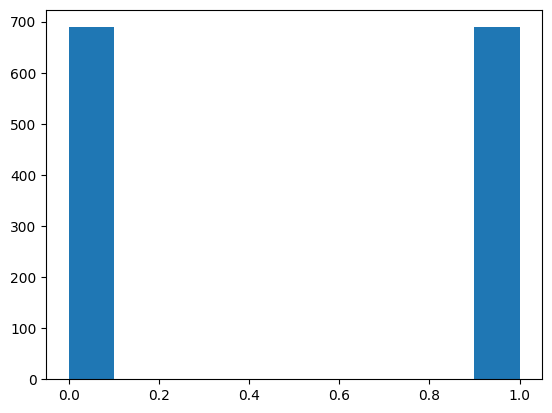

In [168]:
plt.hist(balanced_y)

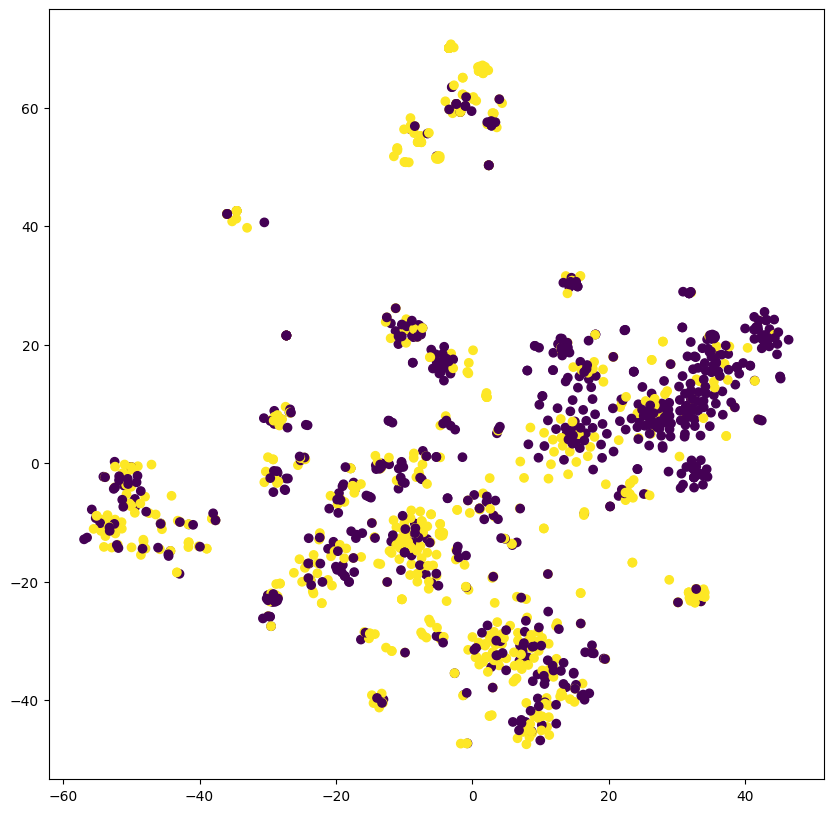

In [169]:
tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(balanced_X)
plt.figure(figsize=(10, 10))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c = balanced_y)
plt.show()

## Обучение

In [170]:
X_train, X_test, y_train, y_test = train_test_split(balanced_X, balanced_y, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)
len(X_train), len(X_val), len(X_test)

(930, 310, 138)

In [171]:
param_grid = {
    'n_neighbors': np.arange(1, 20, 2),
}

search = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, scoring=scoring)
search.fit(X_train, y_train)
y_pred = search.predict(X_val)
print(score(y_val, y_pred))
search.best_params_

0.6943620178041543


{'n_neighbors': 17}

In [172]:
y_pred = search.predict(X_test)
print(f1_score(y_test, y_pred))

0.7058823529411765


In [173]:
param_grid = {
    'max_depth': np.arange(1, 15, 2),
}

search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, scoring=scoring)
search.fit(X_train, y_train)
y_pred = search.predict(X_val)

print(score(y_val, y_pred))
search.best_params_

0.7150837988826815


{'max_depth': 5}

In [174]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(max_depth = 5, verbose=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

print(score(y_val, y_pred))

0.6923076923076922


## Результат на отложенных данных

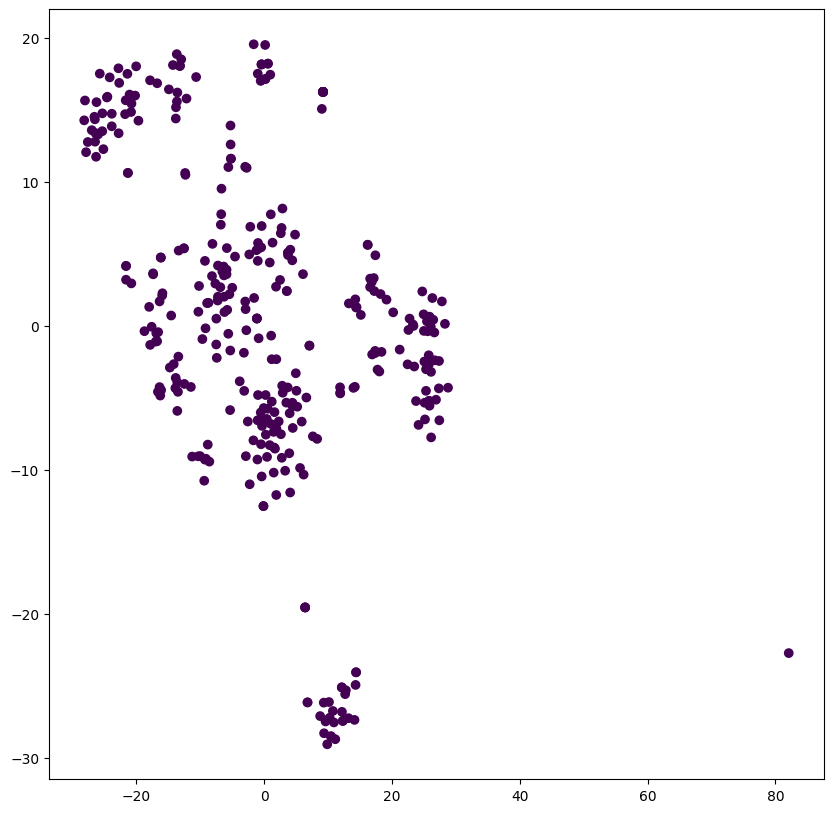

In [175]:
validation_X, validation_y

validation_X_embedded = tsne.fit_transform(validation_X)
plt.figure(figsize=(10, 10))
plt.scatter(validation_X_embedded[:, 0], validation_X_embedded[:, 1], c = validation_y)
plt.show()

In [176]:
y_pred = search.predict(validation_X)
print(score(validation_y, y_pred))
y_pred = search.predict(X_test)
print(score(y_test, y_pred)) 

0.8789808917197451
0.6482758620689654


In [177]:
y_test

array([0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1])

## Обучение на несбалансированных данных

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)
len(X_train), len(X_val), len(X_test)

(1167, 390, 173)

In [179]:
param_grid = {
    'max_depth': np.arange(1, 15, 2),
}

search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, scoring=scoring)
search.fit(X_train, y_train)
y_pred = search.predict(X_val)
print(score(y_val, y_pred))
print(search.best_params_)
y_pred = search.predict(X_test)
print(score(y_test, y_pred))

0.793103448275862
{'max_depth': 3}
0.7946428571428571


In [180]:
param_grid = {
    'n_neighbors': np.arange(1, 25, 2),
}

search = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, scoring=scoring)
search.fit(X_train, y_train)
search.best_params_

{'n_neighbors': 23}

**Метод ближайших соседей занимает слишком много памяти поэтому лучше выбрать градиентный бустинг или рандомфорест**

In [181]:
y_pred = search.predict(X_val)
print(score(y_val, y_pred))
y_pred = search.predict(X_test)
print(score(y_test, y_pred))

0.7741935483870968
0.7881355932203391


# Сохранение лучшей модели и tf-idf

In [182]:
model = RandomForestClassifier(max_depth=3)
model.fit(X, y)
y_pred = model.predict(X_val)
print(y_pred)
print(recall_score(y_val, y_pred))
print(precision_score(y_val, y_pred))
print(balanced_accuracy_score(y_val, y_pred))
print(f1_score(y_val, y_pred))

[1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0
 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1
 1 1 1 0 0 1 0 0 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1
 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1
 1 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 0 1 1 1 0 1 0 1 0 1
 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1
 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0
 1 1 0 0 0 0 1 0 1 0 0 1 1 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 0 0 1 0
 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1]
0.8702928870292888
0.7323943661971831
0.6834908143755716
0.7954110898661569


In [183]:
with open('../service/best_model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('../service/best_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

In [184]:

y_pred = loaded_model.predict(X_val)
print(y_pred)
print(recall_score(y_val, y_pred))
print(precision_score(y_val, y_pred))
print(balanced_accuracy_score(y_val, y_pred))

[1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0
 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1
 1 1 1 0 0 1 0 0 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1
 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1
 1 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 0 1 1 1 0 1 0 1 0 1
 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1
 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0
 1 1 0 0 0 0 1 0 1 0 0 1 1 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 0 0 1 0
 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1]
0.8702928870292888
0.7323943661971831
0.6834908143755716


In [185]:
with open('../service/tfidf.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

with open('../service/tfidf.pkl', 'rb') as f:
    loaded_vectorizer = pickle.load(f)